# I/ Extraction des données sur un seul trail

Pour me faire la main sur les fichiers gpx, je vais d'abord extraire les données de vitesse, d'altitude de mon trail. Ensuite je vais tracer un graphe représentant la vitesse en fonction de l'altitude.

In [1]:
pip install gpxpy pandas matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [12]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from math import radians, sin, cos, sqrt, atan2  

with open('Montagnhard.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
points = gpx.tracks[0].segments[0].points
print(f"Nombre de points extraits : {len(points)}")

Nombre de points extraits : 34768


In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

data = []

for i in range(1, len(points)):
    prev_point = points[i-1]
    curr_point = points[i]
    altitude = curr_point.elevation
    time_diff = (curr_point.time - prev_point.time).total_seconds()
    if time_diff == 0:
        continue
    distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                  curr_point.latitude, curr_point.longitude)
    speed = (distance / time_diff) * 3.6
    data.append({'altitude': altitude, 'vitesse': speed})

df = pd.DataFrame(data)

print(df.describe())


           altitude       vitesse
count  34766.000000  34766.000000
mean    1749.806938      5.427373
std      376.998455      2.602523
min     1126.000000     -0.003606
25%     1441.000000      3.376830
50%     1775.000000      4.815037
75%     1996.000000      7.431600
max     2518.000000     17.617004


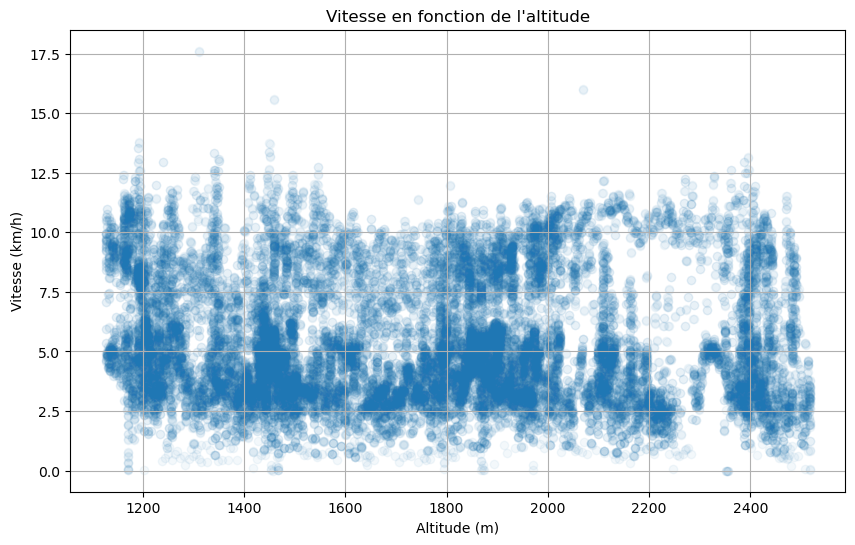

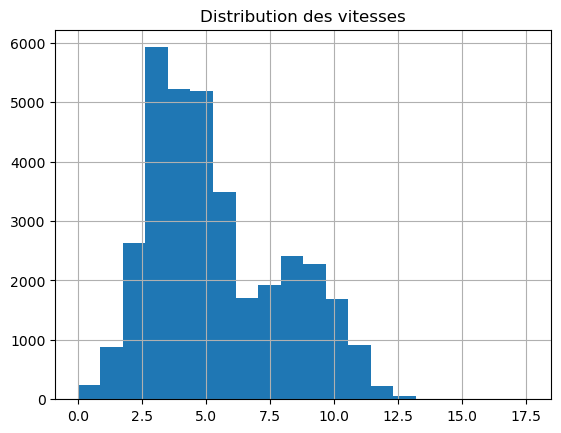

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df['altitude'], df['vitesse'], alpha=0.05)
plt.title('Vitesse en fonction de l\'altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Vitesse (km/h)')
plt.grid(True)
plt.show()
df['vitesse'].hist(bins=20)
plt.title('Distribution des vitesses')
plt.show()


Mission réussie ! On a la distribution des vitesse, on peut voir que j'étais le plus souvent entre 2.5 km/h et 5 km/h, cela représente les longues montées. On a réussi à représenter la vitesse en fonction de l'altitude pour ce trail.

# II/ Extraction des données moyennes entre 3 trails

Le but de cette partie est de combiner mes 3 courses afin d'avoir des données plus larges

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


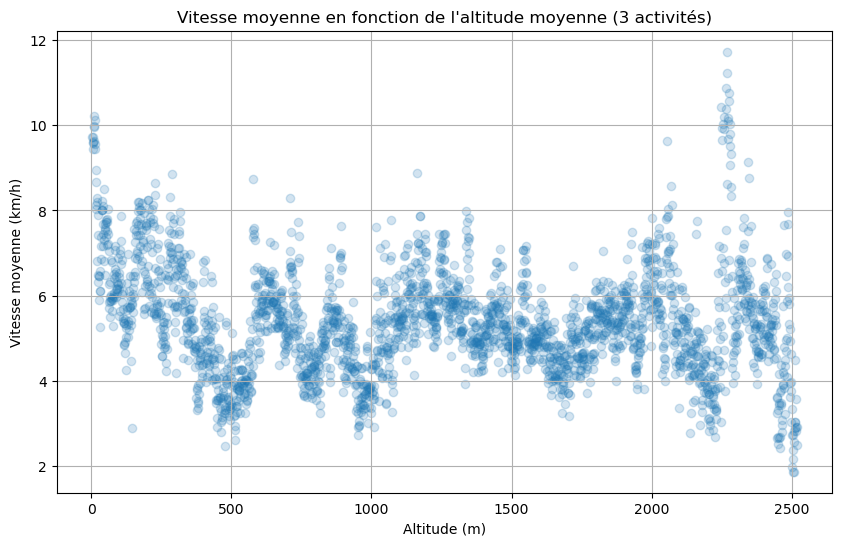

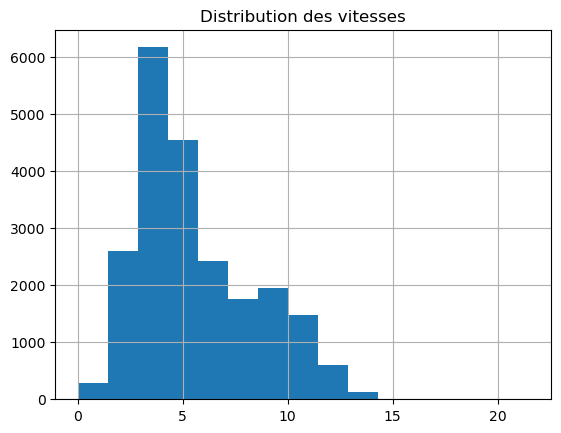

In [15]:
gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        for i in range(1, len(points)):
            prev_point = points[i-1]
            curr_point = points[i]
            altitude = curr_point.elevation
            if altitude is None:
                continue
            time_diff = (curr_point.time - prev_point.time).total_seconds()
            if time_diff == 0:
                continue
            distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                        curr_point.latitude, curr_point.longitude)
            speed = (distance / time_diff) * 3.6
            data.append({'altitude': altitude, 'vitesse': speed})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df['altitude_arrondie'] = combined_df['altitude'].round(0)

mean_data = combined_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(mean_data['altitude_arrondie'], mean_data['vitesse'], alpha=0.2)
plt.title('Vitesse moyenne en fonction de l\'altitude moyenne (3 activités)')
plt.xlabel('Altitude (m)')
plt.ylabel('Vitesse moyenne (km/h)')
plt.grid(True)
plt.show()
df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses')
plt.show()


Mission réussie. On peut voir que la majorité du temps est passée à marcher entre 3 et 6 km/h environ. 
Cependant je trouve que comparer la vitesse en fonction de l'altitude sans prendre en compte l'inclinaison du terrain (montée, plat ou descente) ne permet pas de tirer des enseignements clairs du graphe. Je vais maintenant créer 3 moyennes de vitesses en fonctionn de l'inclinaison.

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


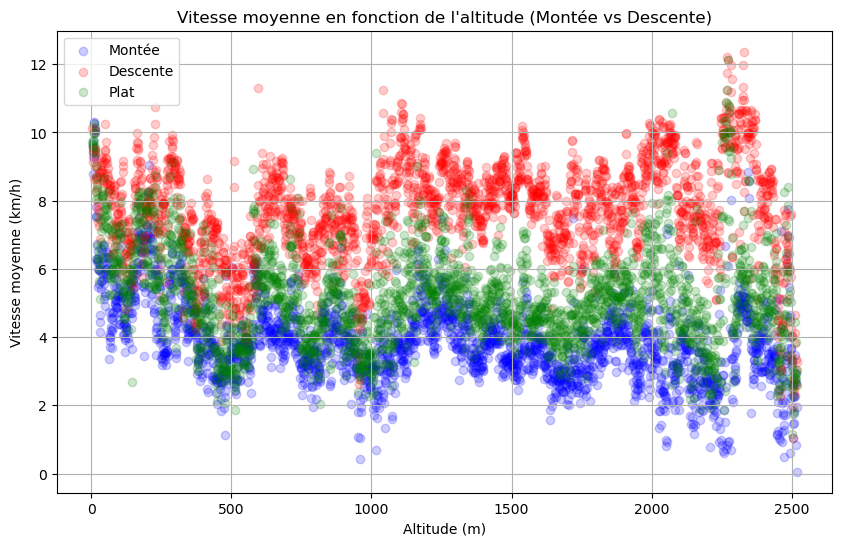

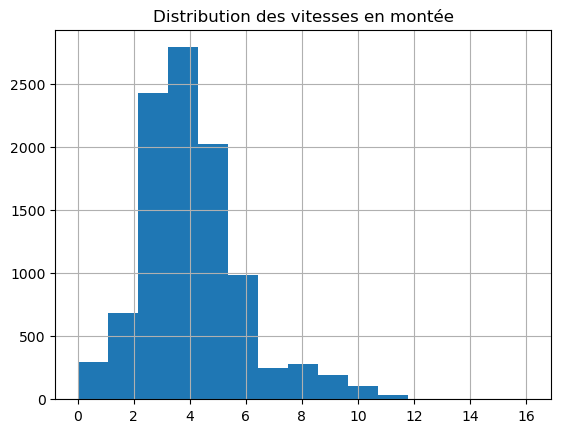

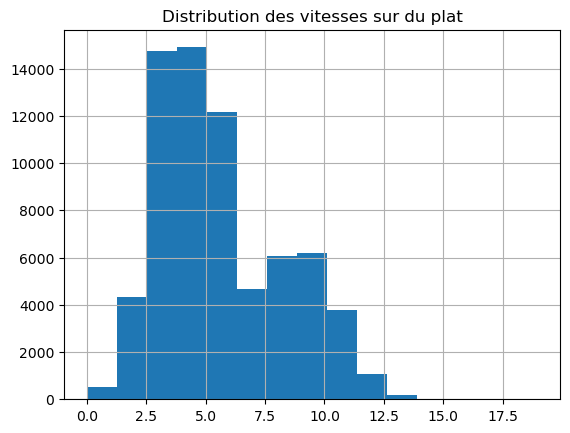

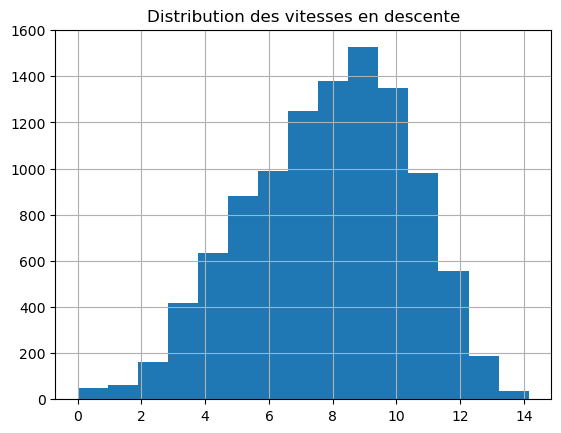

In [16]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2


def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        for i in range(1, len(points)):
            prev_point = points[i-1]
            curr_point = points[i]
            altitude = curr_point.elevation
            prev_altitude = prev_point.elevation
            if altitude is None or prev_altitude is None:
                continue
            time_diff = (curr_point.time - prev_point.time).total_seconds()
            if time_diff == 0:
                continue
            distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                        curr_point.latitude, curr_point.longitude)
            speed = (distance / time_diff) * 3.6
            altitude_diff = altitude - prev_altitude
            if altitude_diff > 0:
                direction = 'montée'
            elif altitude_diff < 0:
                direction = 'descente'
            else:
                direction = 'plat'
            data.append({'altitude': altitude, 'vitesse': speed, 'direction': direction})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

        
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df['vitesse'] < 20]
combined_df['altitude_arrondie'] = combined_df['altitude'].round(0)


montee_df = combined_df[combined_df['direction'] == 'montée']
descente_df = combined_df[combined_df['direction'] == 'descente']
plat_df = combined_df[combined_df['direction'] == 'plat']


mean_montee = montee_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()
mean_descente = descente_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()
mean_plat = plat_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(mean_montee['altitude_arrondie'], mean_montee['vitesse'], color='blue', alpha=0.2, label='Montée')
plt.scatter(mean_descente['altitude_arrondie'], mean_descente['vitesse'], color='red', alpha=0.2, label='Descente')
plt.scatter(mean_plat['altitude_arrondie'], mean_plat['vitesse'], color='green', alpha=0.2, label='Plat')
plt.title('Vitesse moyenne en fonction de l\'altitude (Montée vs Descente)')
plt.xlabel('Altitude (m)')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()


montee_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses en montée')
plt.show()
plat_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses sur du plat')
plt.show()
descente_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses en descente')
plt.show()

On observe bien la différence entre les vitesses en montée/plat/descente. Observation surprenante: une majorité du temps à plat à une vitesse de marche alors que les phases de marche à plat sont rares. Hypothèse: Peut-être que l'intervalle de temps entre deux points gps est trop court pour detecter une différence d'altitude par moment. Cela enverrait alors ces points gps dans le dataframe plat alors qu'ils sont en montée.
Le graphe liant vitesse et altitude n'est pas forcément très lisible, je vais essayer d'améliorer ça.

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


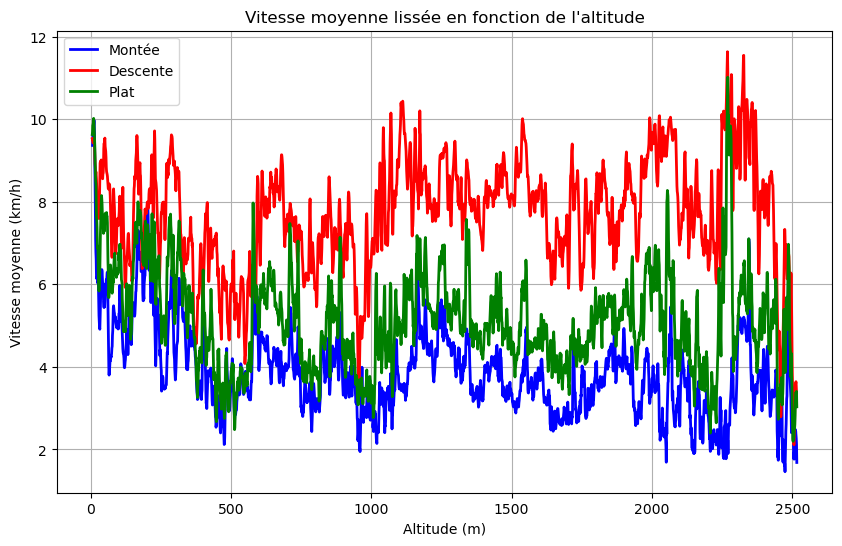

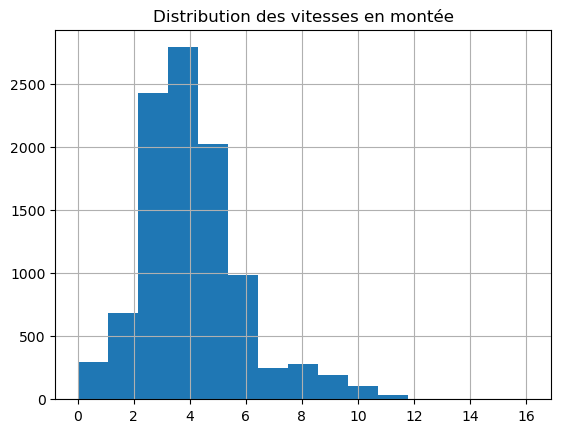

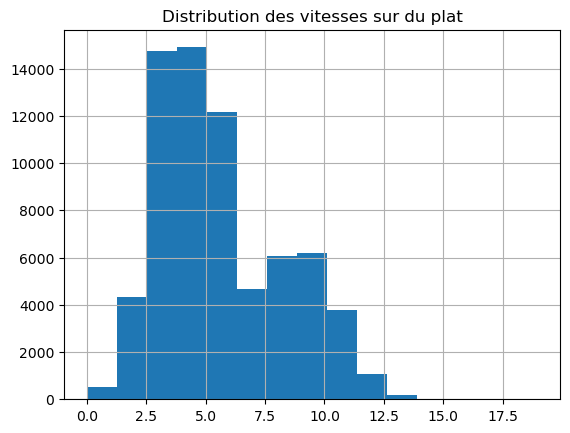

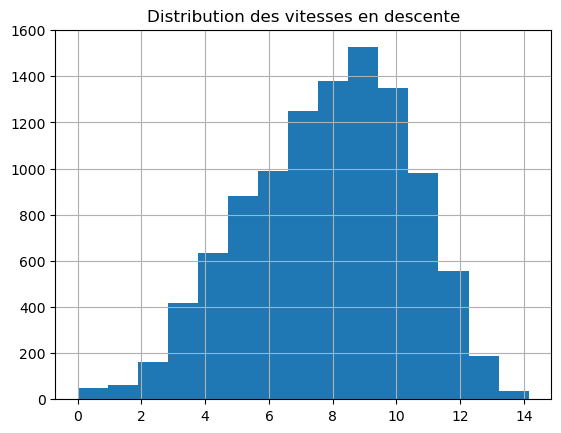

In [17]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        for i in range(1, len(points)):
            prev_point = points[i-1]
            curr_point = points[i]
            altitude = curr_point.elevation
            prev_altitude = prev_point.elevation
            if altitude is None or prev_altitude is None:
                continue
            time_diff = (curr_point.time - prev_point.time).total_seconds()
            if time_diff == 0:
                continue
            distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                        curr_point.latitude, curr_point.longitude)
            speed = (distance / time_diff) * 3.6
            altitude_diff = altitude - prev_altitude
            if altitude_diff > 0:
                direction = 'montée'
            elif altitude_diff < 0:
                direction = 'descente'
            else:
                direction = 'plat'
            data.append({'altitude': altitude, 'vitesse': speed, 'direction': direction})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

        
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df['vitesse'] < 20]
combined_df['altitude_arrondie'] = combined_df['altitude'].round(0)


montee_df = combined_df[combined_df['direction'] == 'montée']
descente_df = combined_df[combined_df['direction'] == 'descente']
plat_df = combined_df[combined_df['direction'] == 'plat']


mean_montee = montee_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()
mean_descente = descente_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()
mean_plat = plat_df.groupby('altitude_arrondie')['vitesse'].mean().reset_index()


mean_montee['vitesse_lissee'] = mean_montee['vitesse'].rolling(window=5, center=True).mean()
mean_descente['vitesse_lissee'] = mean_descente['vitesse'].rolling(window=5, center=True).mean()
mean_plat = combined_df[combined_df['direction'] == 'plat'].groupby('altitude_arrondie')['vitesse'].mean().reset_index()
mean_plat['vitesse_lissee'] = mean_plat['vitesse'].rolling(window=5, center=True).mean()


plt.figure(figsize=(10, 6))
plt.plot(mean_montee['altitude_arrondie'], mean_montee['vitesse_lissee'], color='blue', label='Montée', linewidth=2)
plt.plot(mean_descente['altitude_arrondie'], mean_descente['vitesse_lissee'], color='red', label='Descente', linewidth=2)
plt.plot(mean_plat['altitude_arrondie'], mean_plat['vitesse_lissee'], color='green', label='Plat', linewidth=2)
plt.title('Vitesse moyenne lissée en fonction de l\'altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()


montee_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses en montée')
plt.show()


plat_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses sur du plat')
plt.show()


descente_df['vitesse'].hist(bins=15)
plt.title('Distribution des vitesses en descente')
plt.show()

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


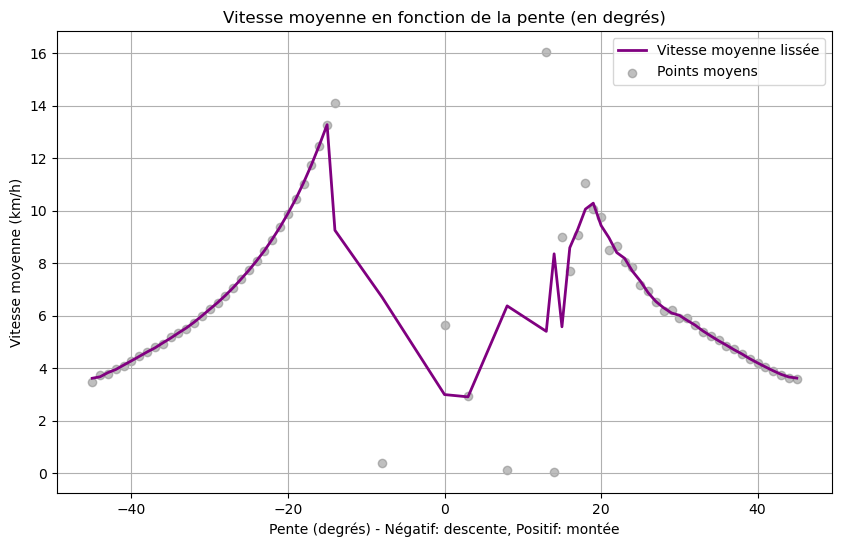

    pente_arrondie   vitesse
0            -45.0  3.485150
1            -44.0  3.745816
2            -43.0  3.785177
3            -42.0  3.959965
4            -41.0  4.098668
..             ...       ...
64            41.0  4.049296
65            42.0  3.901580
66            43.0  3.746536
67            44.0  3.641951
68            45.0  3.601461

[69 rows x 2 columns]


In [18]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2


def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        for i in range(1, len(points)):
            prev_point = points[i-1]
            curr_point = points[i]
            altitude = curr_point.elevation
            prev_altitude = prev_point.elevation
            if altitude is None or prev_altitude is None:
                continue
            time_diff = (curr_point.time - prev_point.time).total_seconds()
            if time_diff == 0:
                continue
            distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                        curr_point.latitude, curr_point.longitude)
            if distance == 0:
                continue
            altitude_diff = altitude - prev_altitude
            pente_rad = math.atan(altitude_diff / distance)
            pente_deg = math.degrees(pente_rad)
            speed = (distance / time_diff) * 3.6
            data.append({'pente_deg': pente_deg, 'vitesse': speed})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

        
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[(combined_df['vitesse'] < 20) & (abs(combined_df['pente_deg']) < 45)]
combined_df['pente_arrondie'] = combined_df['pente_deg'].round(0)


mean_data = combined_df.groupby('pente_arrondie')['vitesse'].mean().reset_index()
mean_data = mean_data.sort_values('pente_arrondie')
mean_data['vitesse_lissee'] = mean_data['vitesse'].rolling(window=3, center=True, min_periods=1).mean()


plt.figure(figsize=(10, 6))
plt.plot(mean_data['pente_arrondie'], mean_data['vitesse_lissee'], color='purple', label='Vitesse moyenne lissée', linewidth=2)
plt.scatter(mean_data['pente_arrondie'], mean_data['vitesse'], color='gray', alpha=0.5, label='Points moyens')
plt.title('Vitesse moyenne en fonction de la pente (en degrés)')
plt.xlabel('Pente (degrés) - Négatif: descente, Positif: montée')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()

print(mean_data[['pente_arrondie', 'vitesse']])

On arrive bien à sortir un graphe reliant vitesse et degré de la pente seulement certaines valeurs semblent aberrantes: je suis loin de courir à 10 km/h de moyenne dans du 20%... Je pense que cette erreur est dûe au fait que les points gps sont enregistrées trop fréquemment pour palier aux erreurs de l'altimètre. Cela peut donc entrainer virtuellement des gains de 5-10m d'altitude en qq secondes alors que ce n'est pas le cas. Je vais allonger l'intervalles de prise en compte des points gps pour essayer d'effacer ces erreurs.

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


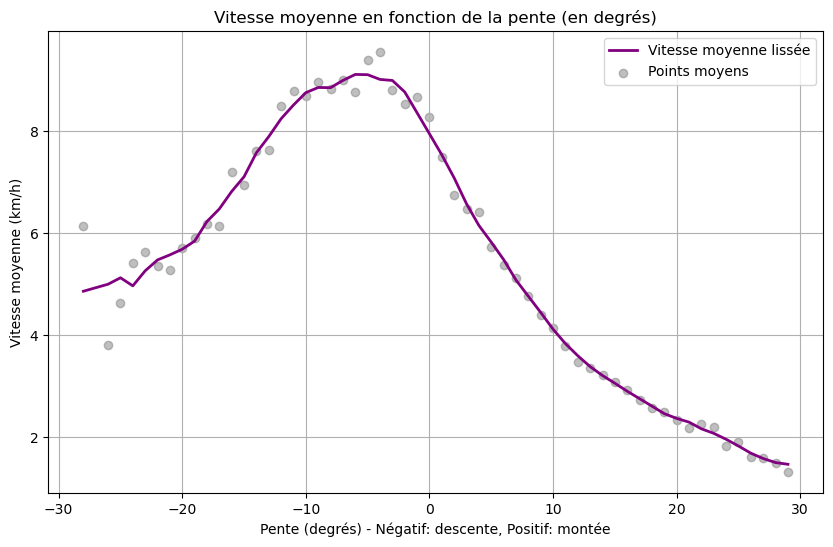

    pente_arrondie   vitesse
0            -28.0  6.133682
1            -26.0  3.810974
2            -25.0  4.630541
3            -24.0  5.411599
4            -23.0  5.625565
5            -22.0  5.343818
6            -21.0  5.283635
7            -20.0  5.700911
8            -19.0  5.906094
9            -18.0  6.180257
10           -17.0  6.140759
11           -16.0  7.204813
12           -15.0  6.937002
13           -14.0  7.618730
14           -13.0  7.622058
15           -12.0  8.492720
16           -11.0  8.791235
17           -10.0  8.690143
18            -9.0  8.961512
19            -8.0  8.834838
20            -7.0  8.996921
21            -6.0  8.772650
22            -5.0  9.402473
23            -4.0  9.546454
24            -3.0  8.809302
25            -2.0  8.532928
26            -1.0  8.671167
27             0.0  8.274025
28             1.0  7.498359
29             2.0  6.752235
30             3.0  6.468516
31             4.0  6.405756
32             5.0  5.733649
33            

In [19]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

seuil_distance = 50

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        i = 1
        while i < len(points):
            start_point = points[i-1]
            cum_distance = 0
            cum_altitude_diff = 0
            cum_time_diff = 0
            while i < len(points) and cum_distance < seuil_distance:
                prev_point = points[i-1]
                curr_point = points[i]
                if curr_point.elevation is None or prev_point.elevation is None:
                    i += 1
                    continue
                time_diff = (curr_point.time - prev_point.time).total_seconds()
                if time_diff == 0:
                    i += 1
                    continue
                distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                              curr_point.latitude, curr_point.longitude)
                cum_distance += distance
                cum_altitude_diff += (curr_point.elevation - prev_point.elevation)
                cum_time_diff += time_diff
                i += 1
            if cum_distance >= seuil_distance and cum_time_diff > 0:
                if cum_distance > 0:
                    pente_rad = math.atan(cum_altitude_diff / cum_distance)
                    pente_deg = math.degrees(pente_rad)
                else:
                    pente_deg = 0
                speed = (cum_distance / cum_time_diff) * 3.6
                data.append({'pente_deg': pente_deg, 'vitesse': speed})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[(combined_df['vitesse'] < 20) & (abs(combined_df['pente_deg']) < 40)]
combined_df['pente_arrondie'] = combined_df['pente_deg'].round(0)

mean_data = combined_df.groupby('pente_arrondie')['vitesse'].mean().reset_index()
mean_data = mean_data.sort_values('pente_arrondie')
mean_data['vitesse_lissee'] = mean_data['vitesse'].rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_data['pente_arrondie'], mean_data['vitesse_lissee'], color='purple', label='Vitesse moyenne lissée', linewidth=2)
plt.scatter(mean_data['pente_arrondie'], mean_data['vitesse'], color='gray', alpha=0.5, label='Points moyens')
plt.title('Vitesse moyenne en fonction de la pente (en degrés)')
plt.xlabel('Pente (degrés) - Négatif: descente, Positif: montée')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()

print(mean_data[['pente_arrondie', 'vitesse']])


Voila qui est bien mieux! Je vais essayer de mettre en valeur ma zone de vitesse max moyenne

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


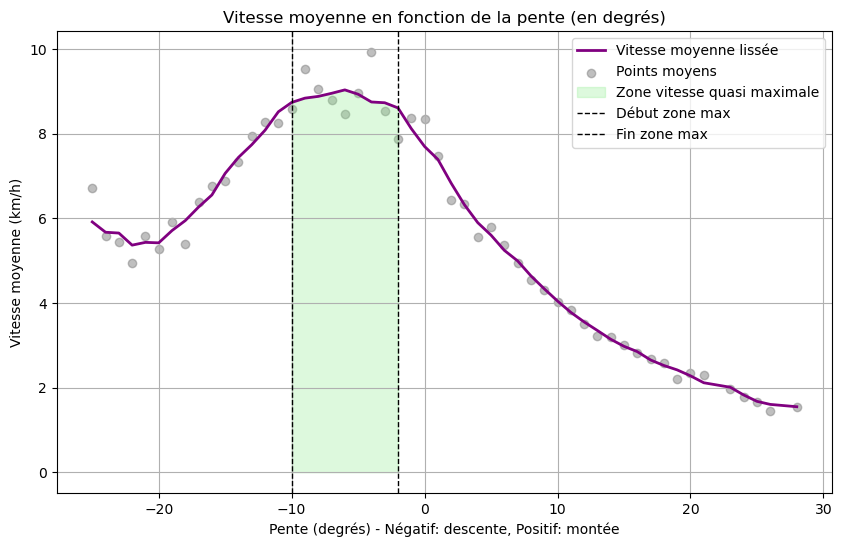

    pente_arrondie   vitesse
0            -25.0  6.709227
1            -24.0  5.589290
2            -23.0  5.449826
3            -22.0  4.939774
4            -21.0  5.576111
5            -20.0  5.280316
6            -19.0  5.917277
7            -18.0  5.392583
8            -17.0  6.391724
9            -16.0  6.757899
10           -15.0  6.879251
11           -14.0  7.343607
12           -13.0  7.948718
13           -12.0  8.278660
14           -11.0  8.257069
15           -10.0  8.589967
16            -9.0  9.521884
17            -8.0  9.052437
18            -7.0  8.786778
19            -6.0  8.462629
20            -5.0  8.953961
21            -4.0  9.926725
22            -3.0  8.539429
23            -2.0  7.870719
24            -1.0  8.372488
25             0.0  8.343213
26             1.0  7.479776
27             2.0  6.427742
28             3.0  6.344460
29             4.0  5.563151
30             5.0  5.787156
31             6.0  5.368717
32             7.0  4.950321
33            

In [20]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2


def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

seuil_distance = 100

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        i = 1
        while i < len(points):
            start_point = points[i-1]
            cum_distance = 0
            cum_altitude_diff = 0
            cum_time_diff = 0
            while i < len(points) and cum_distance < seuil_distance:
                prev_point = points[i-1]
                curr_point = points[i]
                if curr_point.elevation is None or prev_point.elevation is None:
                    i += 1
                    continue
                time_diff = (curr_point.time - prev_point.time).total_seconds()
                if time_diff == 0:
                    i += 1
                    continue
                distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                              curr_point.latitude, curr_point.longitude)
                cum_distance += distance
                cum_altitude_diff += (curr_point.elevation - prev_point.elevation)
                cum_time_diff += time_diff
                i += 1
            if cum_distance >= seuil_distance and cum_time_diff > 0:
                if cum_distance > 0:
                    pente_rad = math.atan(cum_altitude_diff / cum_distance)
                    pente_deg = math.degrees(pente_rad)
                else:
                    pente_deg = 0
                speed = (cum_distance / cum_time_diff) * 3.6
                data.append({'pente_deg': pente_deg, 'vitesse': speed})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[(combined_df['vitesse'] < 50) & (abs(combined_df['pente_deg']) < 50)]
combined_df['pente_arrondie'] = combined_df['pente_deg'].round(0)

mean_data = combined_df.groupby('pente_arrondie')['vitesse'].mean().reset_index()
mean_data = mean_data.sort_values('pente_arrondie')
mean_data['vitesse_lissee'] = mean_data['vitesse'].rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_data['pente_arrondie'], mean_data['vitesse_lissee'], color='purple', label='Vitesse moyenne lissée', linewidth=2)
plt.scatter(mean_data['pente_arrondie'], mean_data['vitesse'], color='gray', alpha=0.5, label='Points moyens')
plt.fill_between(mean_data['pente_arrondie'], 0, mean_data['vitesse_lissee'], where=(mean_data['pente_arrondie'] >= -10.5) & (mean_data['pente_arrondie'] <= -2), 
                 color='lightgreen', alpha=0.3, label='Zone vitesse quasi maximale')
plt.axvline(x=-10, color='black', linestyle='--', linewidth=1, label='Début zone max')
plt.axvline(x=-2, color='black', linestyle='--', linewidth=1, label='Fin zone max')
plt.title('Vitesse moyenne en fonction de la pente (en degrés)')
plt.xlabel('Pente (degrés) - Négatif: descente, Positif: montée')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()

print(mean_data[['pente_arrondie', 'vitesse']])

Exprimons la pente en %

Nombre de points dans Montagnhard.gpx : 34768
Nombre de points dans Dalmacija.gpx : 32459
Nombre de points dans St_jeoire.gpx : 21910


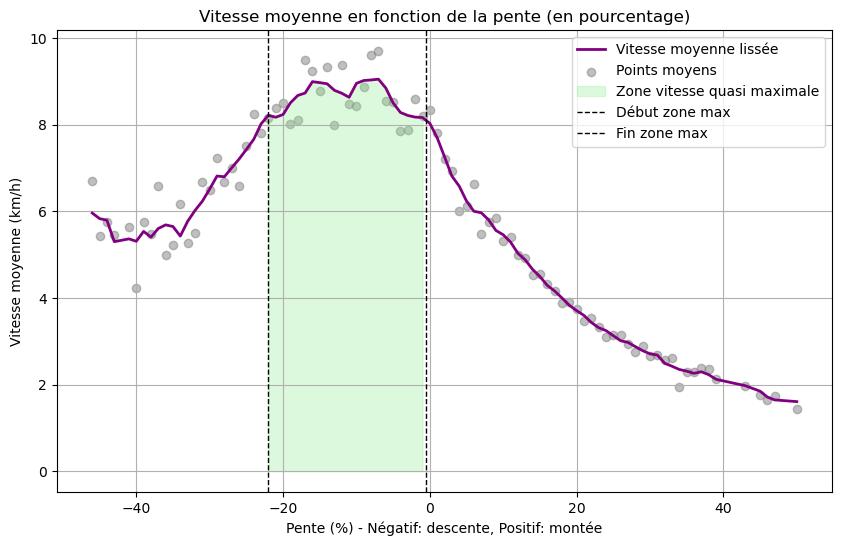

    pente_arrondie   vitesse
0            -46.0  6.709227
1            -45.0  5.432539
2            -44.0  5.746040
3            -43.0  5.449826
4            -41.0  5.645148
..             ...       ...
85            43.0  1.965579
86            45.0  1.767532
87            46.0  1.642376
88            47.0  1.731534
89            50.0  1.447864

[90 rows x 2 columns]


In [21]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2


def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

gpx_files = ['Montagnhard.gpx', 'Dalmacija.gpx', 'St_jeoire.gpx']

seuil_distance = 100

all_data = []

for gpx_file in gpx_files:
    try:
        with open(gpx_file, 'r') as f:
            gpx = gpxpy.parse(f)
        points = gpx.tracks[0].segments[0].points
        print(f"Nombre de points dans {gpx_file} : {len(points)}")
        data = []
        i = 1
        while i < len(points):
            start_point = points[i-1]
            cum_distance = 0
            cum_altitude_diff = 0
            cum_time_diff = 0
            while i < len(points) and cum_distance < seuil_distance:
                prev_point = points[i-1]
                curr_point = points[i]
                if curr_point.elevation is None or prev_point.elevation is None:
                    i += 1
                    continue
                time_diff = (curr_point.time - prev_point.time).total_seconds()
                if time_diff == 0:
                    i += 1
                    continue
                distance = haversine_distance(prev_point.latitude, prev_point.longitude,
                                              curr_point.latitude, curr_point.longitude)
                cum_distance += distance
                cum_altitude_diff += (curr_point.elevation - prev_point.elevation)
                cum_time_diff += time_diff
                i += 1
            if cum_distance >= seuil_distance and cum_time_diff > 0:
                if cum_distance > 0:
                    pente_pourcent = (cum_altitude_diff / cum_distance) * 100
                else:
                    pente_pourcent = 0
                speed = (cum_distance / cum_time_diff) * 3.6
                data.append({'pente_pourcent': pente_pourcent, 'vitesse': speed})
        df = pd.DataFrame(data)
        all_data.append(df)
    except Exception as e:
        print(f"Erreur lors du traitement de {gpx_file} : {e}")

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df[(combined_df['vitesse'] < 20) & (abs(combined_df['pente_pourcent']) < 50)]
combined_df['pente_arrondie'] = combined_df['pente_pourcent'].round(0)

mean_data = combined_df.groupby('pente_arrondie')['vitesse'].mean().reset_index()
mean_data = mean_data.sort_values('pente_arrondie')
mean_data['vitesse_lissee'] = mean_data['vitesse'].rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_data['pente_arrondie'], mean_data['vitesse_lissee'], color='purple', label='Vitesse moyenne lissée', linewidth=2)
plt.scatter(mean_data['pente_arrondie'], mean_data['vitesse'], color='gray', alpha=0.5, label='Points moyens')
plt.fill_between(mean_data['pente_arrondie'], 0, mean_data['vitesse_lissee'], where=(mean_data['pente_arrondie'] >= -22) & (mean_data['pente_arrondie'] <= -0.5), 
                 color='lightgreen', alpha=0.3, label='Zone vitesse quasi maximale')
plt.axvline(x=-22, color='black', linestyle='--', linewidth=1, label='Début zone max')
plt.axvline(x=-0.5, color='black', linestyle='--', linewidth=1, label='Fin zone max')
plt.title('Vitesse moyenne en fonction de la pente (en pourcentage)')
plt.xlabel('Pente (%) - Négatif: descente, Positif: montée')
plt.ylabel('Vitesse moyenne (km/h)')
plt.legend()
plt.grid(True)
plt.show()
print(mean_data[['pente_arrondie', 'vitesse']])

# CONCLUSION

Au final on peut voir que la vitesse moyenne est la plus élevée entre 0 et -22%. C'est cohérent avec mon ressenti terrain, j'ai souvent l'impression de m'accrocher en montée pour ensuite faire la différence en descente. J'ai l'air d'avoir un niveau relatif plus élevé en descente donc. 



Piste d'amélioration pour la saison prochaine: travailler les montées pour gagner en vitesse ascensionnelle. But: étirer la plage de vitesse maximale "sur la droite" -> être plus à l'aise dans les % positifs. Cela passera sûrement par du renforcement bas du corps + triceps (bâtons) 

Travaux suivants: Faire un notebook dédié à la vitesse ascensionnelle en montée et descente (vitesse ascensionnelle negative dans ce cas)